# Leveraging Givens rotations for non-interacting ground state preparation and educated VQE initialization

In this notebook, we show how to prepare the ground state of a non-interacting Hamiltonian ($h_{pqrs} = 0$) on a digital quantum platform using an instance of the LDCA circuit (in its 1-cycle version) that only performs so-called _Givens rotations_. The rotations' angles are determined classically, with a gradient descent. 

In [1]:
import numpy as np
import copy
from matplotlib import pyplot as plt
from qat.qpus import get_default_qpu
from qat.fermion.hamiltonians import make_hubbard_model
from qat.fermion.matchgates import get_nn_rotation_angles
from qat.fermion.circuits import make_ldca_circ

## 1. Definition of the model Hamiltonian

We define a Hubbard model:

In [2]:
# Define an interacting Hubbard (here, Hubbard dimer)
t_mat = 0.25*np.array([[0, 1], [1, 0]])
U = 2
mu = U/2

H = make_hubbard_model(t_mat, U, mu)

eigvals = np.linalg.eigvalsh(H.get_matrix())
E0 = eigvals.min()
print('Ground state energy of the Hubbard dimer Hamiltonian:', eigvals.min())

Ground state energy of the Hubbard dimer Hamiltonian: -2.1180339887498945


Let us remove the interacting part of the Hamiltonian, and see how it affects its ground state energy:

In [3]:
non_interacting_H = copy.deepcopy(H)
non_interacting_H.hpqrs = np.zeros(np.shape(H.hpqrs))

eigvals = np.linalg.eigvalsh(non_interacting_H.get_matrix())
print('Ground state energy of the Hamiltonian without interaction:', eigvals.min())

Ground state energy of the Hamiltonian without interaction: -4.0


## 2. Preparation of the ground state of the non-interacting part

The ground state of a non-interacting (=quadratic) Hamiltonian $H=\sum \limits_{pq} h_{pq} c^{\dagger}_p c_q$ belongs to the class of so-called _gaussian states_. Such states are similar to well-known Slater determinants, except that they are not bound to have a fixed number of particles. 

Similarly to Slater determinants, they can be prepared easily as computational basis states by carrying out a suitable single-particle orbital rotation, namely a transformation $\mathcal{R}(\boldsymbol{\theta}) \in SO(2M)$ acting on the Majorana operators (with $M$ the number of fermionic modes):
$$ \boldsymbol{\gamma'} = \mathcal{R}(\boldsymbol{\theta}) \boldsymbol{\gamma} $$
with $\boldsymbol{\theta} \in \mathbb{R}^d$ the rotation's parameters and $\boldsymbol{\gamma}$ the vector of $2M$ Majorana operators:
    $$\gamma_k = c^{\dagger}_k + c_k ; \gamma_{k+M} = -i(c^{\dagger}_k - c_k) ; 0 \leq k \leq M-1$$.

The rotation $\mathcal{R}$ can be decomposed into _Givens rotations_ that only act either on local modes or on nearest-neighbor modes:
$$ \mathcal{R}(\boldsymbol{\theta}) =\prod \limits_{j=1}^d r_j(\theta_j)$$
which yield a circuit well-suited for linear qubit topology. The target ground state can thus be obtained with a quantum routine as
$$ |\psi_0\rangle = U_{\mathcal{R}(\boldsymbol{\theta})} |\psi_{\mathrm{ref}}\rangle$$

Let's calculate the Givens rotations' angles associated to the ground state of the non-interacting Hamiltonian defined previously:

In [4]:
# Get the rotation angles that allow to reach the ground state of the non interacting hamiltonian
givens_rotation_angles, _ = get_nn_rotation_angles(H.hpq)

nb_angles = len(givens_rotation_angles)
print('Number of Givens rotation angles:', nb_angles) 

Number of Givens rotation angles: 28


To prepare the latter state with myQLM, one can simply use the _Low-Depth Circuit Ansatz_ (LDCA) [(Dallaire-Demers et al., 2018)](https://arxiv.org/abs/1801.01053) in its 1-cycle flavour: this ansatz elaborates on the gaussian states preparation routine presented above -- parametrized by the Givens angles -- to be able to reach a wider class of states, but upon setting its $R_{ZZ}$ gates' parameters to 0, it offers an exact preparation circuit for the state of interest. 

Let us construct the circuit and print its number of parameters:

Number of parameters in 1-cycle LDCA circit on 4 qubits: 34


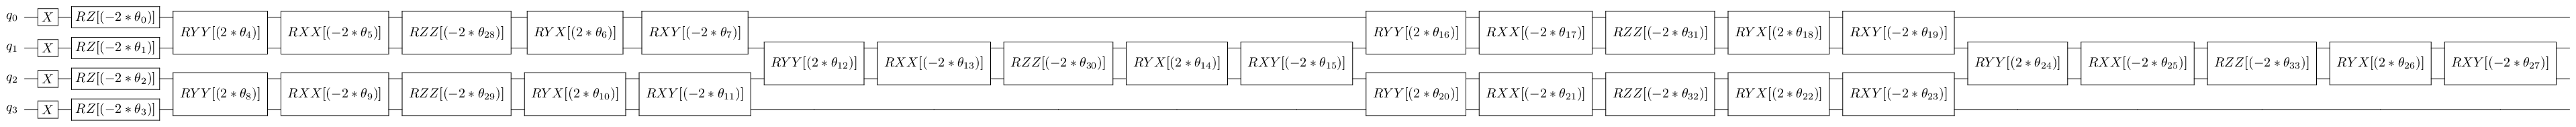

In [5]:
circ = make_ldca_circ(nb_fermionic_modes=4, ncycles=1)

nb_ldca_params = len(circ.var_dic)
print('Number of parameters in 1-cycle LDCA circit on 4 qubits:', nb_ldca_params)

circ.display()

We see that we have 6 $R_{ZZ}$ gates, which is simply the difference between the number of LDCA parameters and the number of Givens rotation angles. The $R_{ZZ}$ angles correspond to the last parameters. Let us thus bind the circuit to the Givens angles completed with 6 vanishing parameters:

In [6]:
nb_other_params = nb_ldca_params - nb_angles

# We set the initial parameters to the Givens rotations, the rest of the parameters beeing set to 0
theta = list(givens_rotation_angles) + [0]*nb_other_params 

# We bind these parameters to the paramterized circuit defined previously
prep_circ = circ.bind_variables({ r"\theta_{%i}"%i : 0.5*theta[i] for i in range(len(theta))})

We should find that the LDCA circuit, parametrized as such, prepares a state whose energy is the ground state energy of the non-interacting Hamiltonian:

In [7]:
job = prep_circ.to_job(job_type="OBS", observable=non_interacting_H.to_spin())
qpu = get_default_qpu()

# evaluate energy of bound circuit
res = qpu.submit(job)
print("Expectation value of the non interacting part of the Hamiltonian on the quantum circuit:", res.value)

This program is trying to run a QPU of class CLinalg that does not implement resource management on a computer where resource management is mandatory.  You should implement estimate_resources_for_batch() in this class, else you will lose the guarantees provided by resource management.


Expectation value of the non interacting part of the Hamiltonian on the quantum circuit: -3.9999961605393475


This is indeed very close to the value we computed at the start of the notebook !